In [1]:
import xarray as xr
import gcsfs
import intake
import numpy as np
import matplotlib
#import cmocean
import stats
import stats as st
from matplotlib import pyplot as plt
import scipy.signal as signal
import xgcm
import importlib
import llcmapping
from llcmapping import LLCMapper
%matplotlib inline
importlib.reload(llcmapping)
importlib.reload(stats)


/srv/conda/envs/notebook/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


<module 'stats' from '/home/jovyan/stats.py'>

In [2]:
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.titlesize': 18})
matplotlib.rcParams.update({'figure.figsize': (10,8)})
matplotlib.rcParams.update({'lines.linewidth': 2})
matplotlib.rcParams.update({'legend.fontsize': 18})
matplotlib.rcParams.update({'mathtext.fontset': 'cm'})
matplotlib.rcParams.update({'ytick.major.size': 3})
matplotlib.rcParams.update({'axes.labelsize': 16})
matplotlib.rcParams.update({'ytick.labelsize': 16})
matplotlib.rcParams.update({'xtick.labelsize': 16})

In [3]:
cat = intake.open_catalog('catalog.yaml')
ds = cat.ECCOv4r3.to_dask()
ds

<xarray.Dataset>
Dimensions:    (face: 13, i: 90, i_g: 90, j: 90, j_g: 90, k: 50, k_l: 50, k_p1: 51, k_u: 50, time: 288, time_snp: 287)
Coordinates:
    Depth      (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    PHrefC     (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    PHrefF     (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    XC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    XG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YC         (face, j, i) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    YG         (face, j_g, i_g) float32 dask.array<shape=(13, 90, 90), chunksize=(13, 90, 90)>
    Z          (k) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zl         (k_l) float32 dask.array<shape=(50,), chunksize=(50,)>
    Zp1        (k_p1) float32 dask.array<shape=(51,), chunksize=(51,)>
    Zu         (k_u) float32 dask.array<

In [4]:
# Load mixed layer depth from my Google cloud bucket 
ds_MXLDEPTH = xr.open_zarr(gcsfs.GCSMap('ecco-data/MXLDEPTH'))

In [5]:
# a trick to make things work a bit faster
coords = ds.coords.to_dataset().reset_coords()
ds = ds.reset_coords(drop=True)

In [6]:
mxldepth = ds_MXLDEPTH.MXLDEPTH
mxldepth.coords['i'] = coords['i']
mxldepth.coords['j'] = coords['j']

In [7]:
# Calculate mean mixed layer depth
mxldepth_clim=mxldepth.mean(dim='time').load()

In [13]:
#from dask.distributed import Client, progress
#from dask_kubernetes import KubeCluster
#cluster = KubeCluster(n_workers=20)
#cluster

/srv/conda/envs/notebook/lib/python3.6/site-packages/distributed/dashboard/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


In [26]:
#client = Client(cluster)
#client

Client Scheduler: tcp://10.49.92.8:43069 Dashboard: /user/cpatrizio88-pan-_binder_example-9jt7c0bd/proxy/35853/status,Cluster Workers: 15 Cores: 30 Memory: 105.00 GB


In [8]:
%time ds.THETA.isel(k=0).mean(dim='time').load()

CPU times: user 38.3 s, sys: 23.4 s, total: 1min 1s
Wall time: 29.9 s


<xarray.DataArray 'THETA' (face: 13, j: 90, i: 90)>
array([[[ 0.      ,  0.      , ...,  0.      ,  0.      ],
        [ 0.      ,  0.      , ...,  0.      ,  0.      ],
        ...,
        [ 0.432548,  0.420362, ...,  0.243915,  0.291386],
        [ 0.653515,  0.658455, ...,  0.427649,  0.498188]],

       [[ 0.872101,  0.891548, ...,  0.602339,  0.697784],
        [ 1.096168,  1.117599, ...,  0.774091,  0.891288],
        ...,
        [27.589699, 27.559296, ..., 26.44383 , 26.62003 ],
        [27.37777 , 27.343906, ...,  0.      , 26.430416]],

       ...,

       [[27.479862, 27.624815, ...,  5.60189 ,  5.157408],
        [27.488213, 27.622663, ...,  5.657171,  5.213162],
        ...,
        [27.444382, 27.641308, ...,  1.204041,  1.031747],
        [27.411293, 27.615599, ...,  1.113161,  0.912151]],

       [[ 4.696424,  4.21946 , ...,  0.      ,  0.      ],
        [ 4.747999,  4.27007 , ...,  0.      ,  0.      ],
        ...,
        [ 0.851896,  0.651258, ...,  0.      ,  0. 

In [9]:
theta = ds.THETA
Qs = ds.TFLUX
Qsw = ds.oceQsw

In [10]:
theta_anom = st.anom(theta)
Qs_anom = st.anom(Qs)

In [11]:
Qsw_anom = st.anom(Qsw)

In [12]:
THF_anom = -(Qs_anom - Qsw_anom)
sst_anom = theta_anom.isel(k=0)

In [13]:
# Standard deviation
sst_std = sst_anom.std(dim='time').load()

In [51]:
# Detrending
sst_anom = xr.DataArray(signal.detrend(sst_anom, axis=0), dims=sst_anom.dims, coords=sst_anom.coords)

In [52]:
THF_anom = xr.DataArray(signal.detrend(THF_anom, axis=0), dims=THF_anom.dims, coords=THF_anom.coords)

In [69]:
# Compute covariance 
#covs = st.cov(sst_anom, THF_anom)
sst_mean = theta.isel(k=0).mean(dim='time')

In [88]:
lags = np.array([-1,0,1])
lagcovs = xr.DataArray(np.empty(sst_mean.shape),dims=sst_mean.dims, coords=sst_mean.coords)
for lag in lags:
    print('lag', lag)
    lagcovs_temp = st.cov(sst_anom, THF_anom, lagx=0,lagy=lag)
    lagcovs = xr.concat([lagcovs, lagcovs_temp], 'lag')    

lag -1
lag 0
lag 1


In [89]:
lagcovs = lagcovs[1:,:]

In [90]:
covs = covs.load()
lagcovs = lagcovs.load()

In [119]:
mapper = LLCMapper(coords)

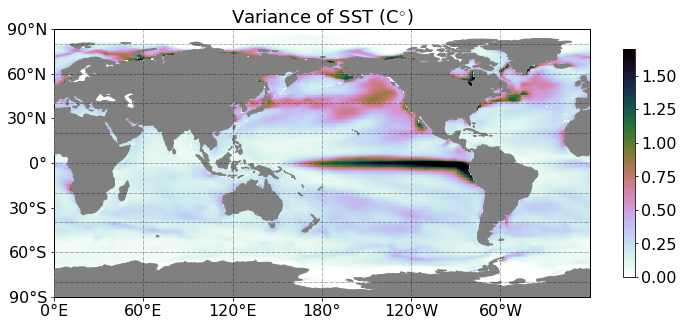

In [123]:
m, ax = mapper(sst_std**2, cmap='cubehelix_r', vmax=1.7, vmin=0);
ax.set_title(r'Variance of SST (C$^{\circ}$)');

(<cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f978d445860>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f978d445860>)

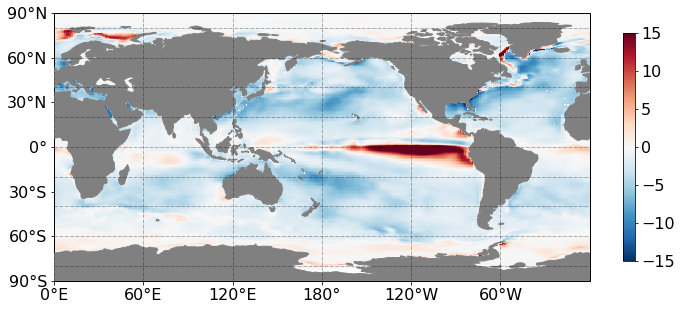

In [120]:
mapper(lagcovs[0,:], cmap='RdBu_r', vmin=-15, vmax=15)

(<cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f9773090080>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f9773090080>)

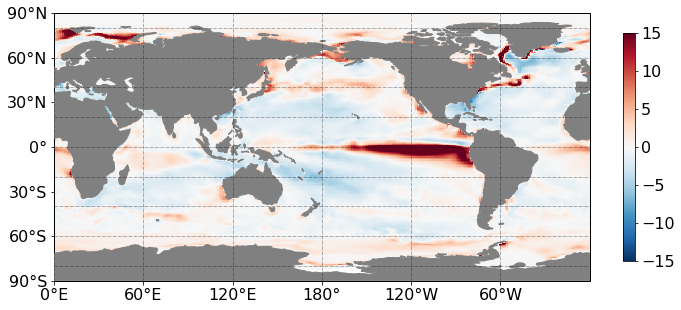

In [92]:
mapper(lagcovs[1,:], cmap='RdBu_r', vmin=-15, vmax=15)

(<cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f9772ac6f28>,
 <cartopy.mpl.geoaxes.GeoAxesSubplot at 0x7f9772ac6f28>)

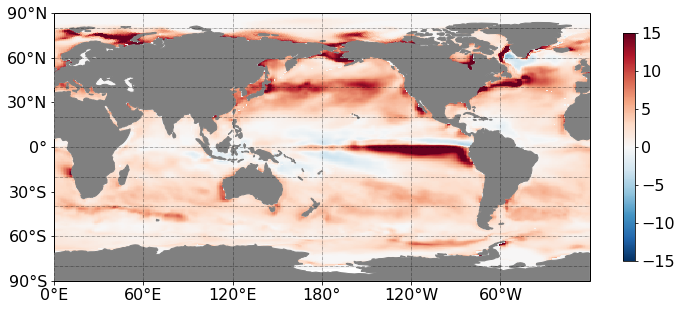

In [93]:
mapper(lagcovs[2,:], cmap='RdBu_r', vmin=-15, vmax=15)